In [39]:
from typing import Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score, KFold
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression

In [2]:
def load_mibig_data_and_metadata():
    LEFTOUT_BGC = 'BGC0001482' # This BGC doesn't have metadata, for some reason.
    mibig = pd.read_csv('mibig_table.tsv', sep='\t')
    mibig = mibig.iloc[:, :17]
    mibig = mibig[mibig['BGC'] != LEFTOUT_BGC]
    
    # Initial set of BGCs with Pfam domains
    bgc_set = set(mibig['BGC'])
    
    mibig_cath = pd.read_csv('mibig_cathdb.tsv', sep='\t')
    mibig_cath = mibig_cath.iloc[:, :-1]
    # Get set of BGCs from CATH to drop
    idx = mibig_cath['BGC'].isin(bgc_set)
    mibig_cath = mibig_cath[idx].reset_index(drop=True)
    
    # Set of BGCs with Pfam _and_ Cath domains
    bgc_set = set(mibig_cath['BGC'])
    
    mibig = mibig[mibig['BGC'].isin(bgc_set)]
    
    # Load the metadata and filter to ones with transporters
    _mibig_meta = pd.read_csv('data_mibig_fixed.tsv', sep='\t') # Lots of stuff with no transporters present
    mibig_meta = _mibig_meta[_mibig_meta['BGC'].isin(bgc_set)].reset_index(drop=True)

    # Make sure mibig_meta and mibig_counts_df agree have same index
    # There should be a clean pandas way to do this, but shrug

    # Create dict with mibig_cath order 
    int_to_bgc = dict(enumerate(mibig_cath['BGC']))
    bgc_to_int = {v: k for k,v in int_to_bgc.items()}
    
    def sort_df(df: pd.DataFrame) -> pd.DataFrame:
        # Now add mibig_order column to df and sort it
        df['idx'] = [bgc_to_int[name] for name in df['BGC']]
        df = df.sort_values(by='idx', ascending=True)

        # Now drop the idx column and reset index
        df = df.drop(columns='idx')
        df = df.reset_index(drop=True)
        
        return df
    
    # Sort pfam and metadata
    mibig_meta = sort_df(mibig_meta)
    mibig = sort_df(mibig)
    
    assert list(mibig_meta['BGC']) == list(mibig['BGC']) == list(mibig_cath['BGC']), 'BGC of metadata and counts do not agree. Check ordering.'
    
    return mibig, mibig_cath, mibig_meta

There are incompatibilities between mibig pfam, mibig cath, and mibig meta. We need to be careful how we resolve all of these

In [3]:
mibig, mibig_cath, mibig_meta = load_mibig_data_and_metadata()

Create some functionality to add or not add hand labels, as desired.

In [4]:
labels_dict = {}
for label_file in ['extra_antibiotics',
                   'extra_antifungal',
                   'extra_siderophore']:
    with open(label_file, 'r') as f:
        labels_dict[label_file] = [x.strip() for x in f.readlines()]
    
# Column name and extra_* file have slightly different names
columns = ['Antibacterial', 'Antifungal', 'Siderophore']
column_dict = {k:v for k,v in zip(labels_dict.keys(), columns)}

In [5]:
def add_hand_labels(input_df: pd.DataFrame,
                    labels: Union['antibiotics', 'antifungal', 'siderophore']) -> pd.DataFrame:
    
    meta_df = input_df.copy(deep=True)
    if isinstance(labels, str):
        labels = [labels] # Hack for feeding in a single label

    # Update desired labels
    for label in labels:
        label = 'extra_' + label
        meta_df.loc[meta_df['Name'].isin(labels_dict[label]), column_dict[label]] = 1
    
    return meta_df

Let's evaluate how many more labels we get with hand labelling vs none

In [6]:
print('Using only metadata of BGCs with transporters:')
print('-'*50)
for label_type in labels_dict.keys():
    label = label_type[6:]
    column = column_dict[label_type]
    orig = np.sum(mibig_meta[column])
    new = np.sum(add_hand_labels(mibig_meta, label)[column])
    
    print(f'Number of mibig labelled {label}: {orig}')
    print(f'Number of mibig and hand labelled {label}: {new}')
    print(f'Number additional examples: {new - orig}')
    print('-'*50)

Using only metadata of BGCs with transporters:
--------------------------------------------------
Number of mibig labelled antibiotics: 121
Number of mibig and hand labelled antibiotics: 154
Number additional examples: 33
--------------------------------------------------
Number of mibig labelled antifungal: 27
Number of mibig and hand labelled antifungal: 31
Number additional examples: 4
--------------------------------------------------
Number of mibig labelled siderophore: 8
Number of mibig and hand labelled siderophore: 44
Number additional examples: 36
--------------------------------------------------


## NOTE

Some of the things you labelled don't have transporters at all. If I use `_mibig_meta` instead of `mibig_meta` (the one that hasn't been filtered to have transporters), we get a bigger delta.

In [7]:
_mibig_meta = pd.read_csv('data_mibig_fixed.tsv', sep='\t')
print('Using ALL metadata')
print('-'*50)
for label_type in labels_dict.keys():
    label = label_type[6:]
    column = column_dict[label_type]
    orig = np.sum(_mibig_meta[column])
    new = np.sum(add_hand_labels(_mibig_meta, label)[column])
    
    print(f'Number of mibig labelled {label}: {orig}')
    print(f'Number of mibig and hand labelled {label}: {new}')
    print(f'Number additional examples: {new - orig}')
    print('-'*50)

Using ALL metadata
--------------------------------------------------
Number of mibig labelled antibiotics: 176
Number of mibig and hand labelled antibiotics: 228
Number additional examples: 52
--------------------------------------------------
Number of mibig labelled antifungal: 61
Number of mibig and hand labelled antifungal: 66
Number additional examples: 5
--------------------------------------------------
Number of mibig labelled siderophore: 13
Number of mibig and hand labelled siderophore: 60
Number additional examples: 47
--------------------------------------------------


The only case where we have to class balance is antifungal vs siderophore after hand-labelling. Let's start by doing that.

In [17]:
df = add_hand_labels(mibig_meta, ['siderophore', 'antifungal'])

# Grab indices where at least one label is good
idx1 = df['Antifungal'] == 1
idx2 = df['Siderophore'] == 1
idx = (df['Antifungal'] == 1) | (df['Siderophore'] == 1)

# Form X and y using these indices
X_pfam = mibig[idx.to_list()].reset_index(drop=True)
y = df['Antifungal'][idx.to_list()] - df['Siderophore'][idx.to_list()]

# Filter any examples with both labels and unneeded columns
nonoverlap_idx = y != 0
X_pfam = X_pfam[nonoverlap_idx.to_list()].reset_index(drop=True)
X_pfam = X_pfam.iloc[:, 1:]
y_pfam = y[nonoverlap_idx.to_list()].reset_index(drop=True)

In [23]:
clf = LogisticRegression(C=1, penalty='l1', tol=0.01, solver='saga')
scores = cross_val_score(clf, X_pfam, y_pfam, cv=5)
scores

array([0.66666667, 0.6       , 0.86666667, 0.5       , 0.64285714])

In [25]:
clf.fit(X_pfam, y_pfam)
coef = clf.coef_.ravel()
np.mean(coef==0) * 100

In [10]:
clf = AdaBoostClassifier(n_estimators=100)
scores = cross_val_score(clf, X_pfam, y_pfam, cv=5)
scores

array([0.8       , 0.66666667, 0.93333333, 0.78571429, 0.85714286])

In [72]:
df = mibig_meta
#df = add_hand_labels(mibig_meta, ['siderophore', 'antifungal'])

# Grab indices where at least one label is good
idx1 = df['Antifungal'] == 1
idx2 = df['Siderophore'] == 1
idx = (df['Antifungal'] == 1) | (df['Siderophore'] == 1)

# Form X and y using these indices
X_cath = mibig_cath[idx.to_list()].reset_index(drop=True)
y = df['Antifungal'][idx.to_list()] - df['Siderophore'][idx.to_list()]

# Filter any examples with both labels and unneeded columns
nonoverlap_idx = y != 0
X_cath = X_cath[nonoverlap_idx.to_list()].reset_index(drop=True)
X_cath = X_cath.iloc[:, 1:]
y_cath = y[nonoverlap_idx.to_list()].reset_index(drop=True)
y_cath = np.array(y_cath)

In [30]:
clf = AdaBoostClassifier(n_estimators=100)
scores = cross_val_score(clf, X_cath, y_cath, cv=5)
scores

array([1.        , 0.85714286, 1.        , 0.83333333, 0.83333333])

In [61]:
scores = []
coefs = []

kf = KFold(n_splits=5)
for train_index, test_index in kf.split(X_cath):
    X_train, X_test = X_cath.iloc[train_index], X_cath.iloc[test_index]
    y_train, y_test = y_cath.iloc[train_index], y_cath.iloc[test_index]
    
    clf = LogisticRegression(C=1, penalty='l1', tol=0.01, solver='saga')
    clf.fit(X_train, y_train)
    scores.append(clf.score(X_test, y_test))
    
    coef = clf.coef_.ravel()
    coefs.append(coef)
    
print(f'Scores for the five splits are {scores} \n')
for i, c in enumerate(coefs):
    print('-'*50)
    print(f'Split {i+1}:')
    nonzero_idx = c != 0
    variables = X_cath.columns[nonzero_idx]
    print(f'{round(np.mean(c == 0)*100, 2)} percent of variables unused')
    print(f'Variables used {list(variables)}')

Scores for the five splits are [1.0, 0.5714285714285714, 0.8571428571428571, 0.8333333333333334, 0.8333333333333334] 

--------------------------------------------------
Split 1:
97.91 percent of variables unused
Variables used ['1.20.1640.10/FF/24538', '2.40.50.100/FF/50279', '1.20.1250.20/FF/180940', '2.40.170.20/FF/26209']
--------------------------------------------------
Split 2:
98.43 percent of variables unused
Variables used ['1.20.1640.10/FF/24538', '1.20.1250.20/FF/180940', '3.40.50.300/FF/627204']
--------------------------------------------------
Split 3:
98.43 percent of variables unused
Variables used ['1.20.1640.10/FF/24538', '1.20.1250.20/FF/180940', '2.40.170.20/FF/26209']
--------------------------------------------------
Split 4:
98.43 percent of variables unused
Variables used ['2.40.50.100/FF/50279', '1.20.1250.20/FF/180940', '2.40.170.20/FF/26209']
--------------------------------------------------
Split 5:
98.43 percent of variables unused
Variables used ['1.20.1

Direct analysis.

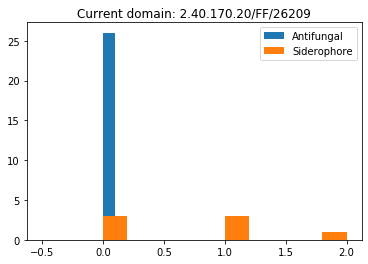

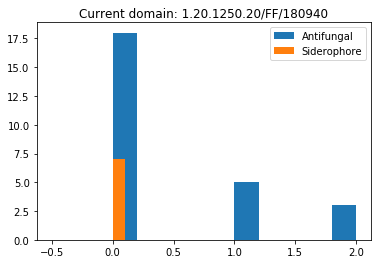

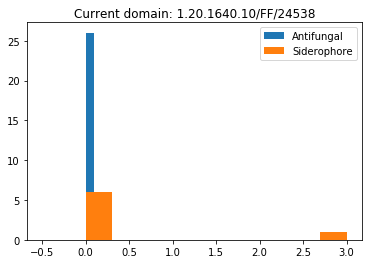

In [74]:
caths_of_interest = ['2.40.170.20/FF/26209', '1.20.1250.20/FF/180940', '1.20.1640.10/FF/24538']
for domain in caths_of_interest:
    plt.title(f'Current domain: {domain}')
    plt.hist(X_cath[domain][y_cath == 1], label='Antifungal')
    plt.hist(X_cath[domain][y_cath == -1], label='Siderophore')
    plt.legend()
    plt.show()

# Questions:

1. How many BGCs in MIBIG can we confidently assert are _none_ of 2 or 3 labels? It seems much more useful to have a negative class with some meaning here. 

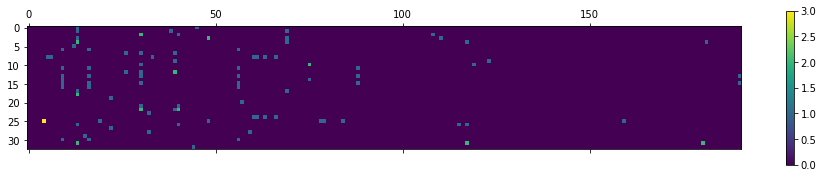

In [13]:
plt.matshow(X_cath)
plt.colorbar()

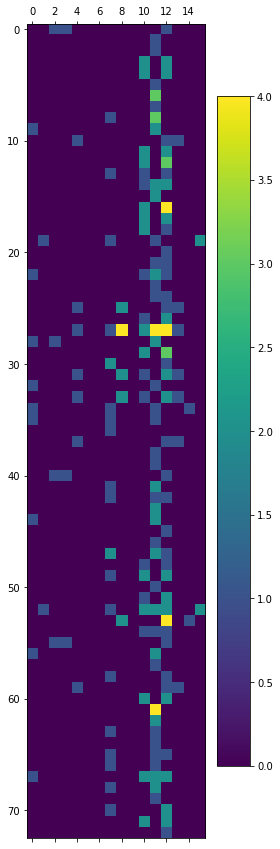

In [14]:
plt.matshow(X_pfam)
plt.colorbar()